# 0.0. IMPORTS

In [71]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime as datetime
from matplotlib.gridspec import GridSpec
import scipy.stats         as stats

from tabulate              import tabulate
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [83]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CrossValidation': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CrossValidation': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CrossValidation': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv("../datasets/train.csv", low_memory=False)
df_store_raw = pd.read_csv("../datasets/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
743290,371,2,2013-09-03,4919,443,1,0,0,0,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS 

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
816108,714,7,2013-06-30,0,0,0,0,0,0,d,c,12070.0,10.0,2005.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct"


In [11]:
#competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis = 1)

#competition_open_since_year
df1["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)
                              
#promo2_since_week
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)

#promo2_since_year
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

#promo_interval
month_map = {1: "Jan",
             2: "Fev",
             3: "Mar",
             4: "Apr",
             5: "May",
             6: "Jun",
             7: "Jul",
             8: "Aug",
             9: "Sep",
             10: "Oct",
             11: "Nov",
             12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)
df1["month_map"] = df1["date"].dt.month.map(month_map)
df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis = 1)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype("int")
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype("int")

df1["promo2_since_week"] = df1["promo2_since_week"].astype("int")
df1["promo2_since_year"] = df1["promo2_since_year"].astype("int")

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=["int","int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int","int64", "float64", "datetime64[ns]"])

In [15]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
216877,0,d,c,"Jan,Apr,Jul,Oct",Jan
791851,0,c,a,0,Jul


### 1.7.1. Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

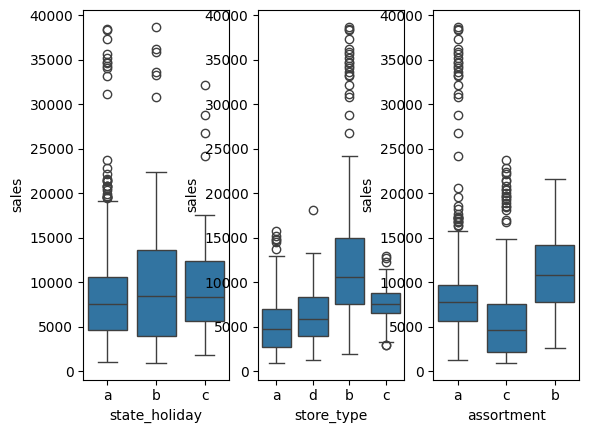

In [19]:

aux1 = df1[(df1["state_holiday"] != '0') & (df1["sales"] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday",y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x="store_type",y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x="assortment",y="sales", data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

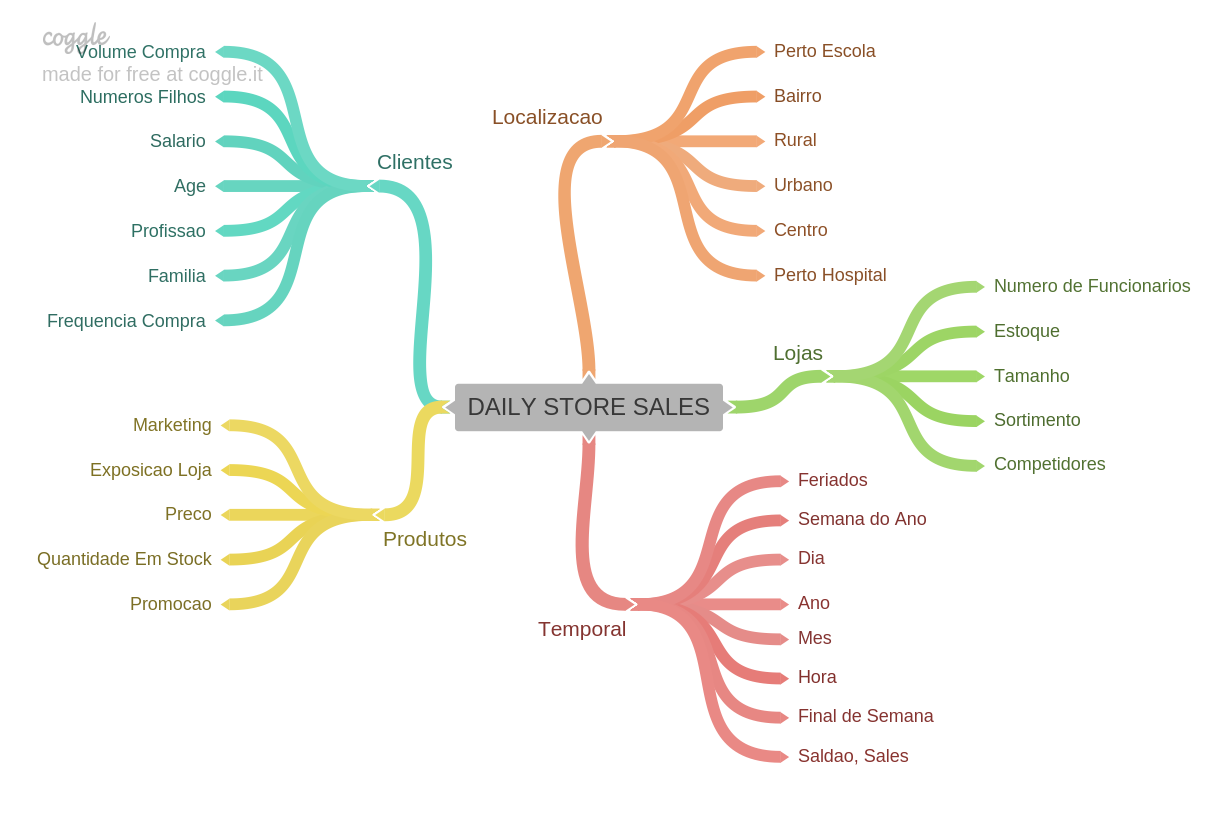

In [21]:
Image("../img/MindMapHypothesis.png")

## 2.2. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [22]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

# competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"],
                  month=x["competition_open_since_month"], day=1), axis=1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2["promo_since"] = df2["promo2_since_year"].astype(str) + '-' + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2["promo_time_week"]= ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [24]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [25]:
#excluímos colunas não relevantes pro negócio
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [26]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

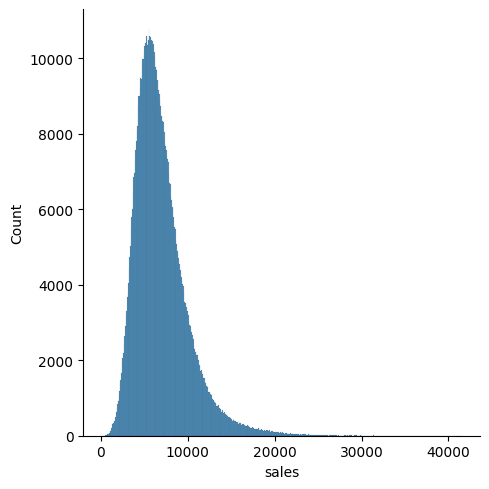

In [27]:
sns.displot(df4["sales"])

### 4.1.2. Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

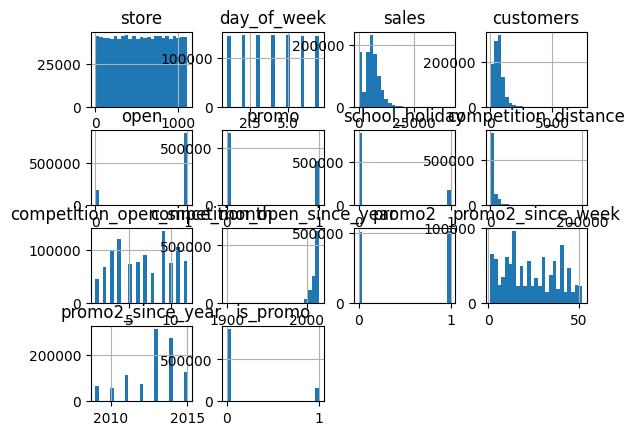

In [28]:
num_attributes.hist(bins=25)

### 4.1.3. Categorical Variable

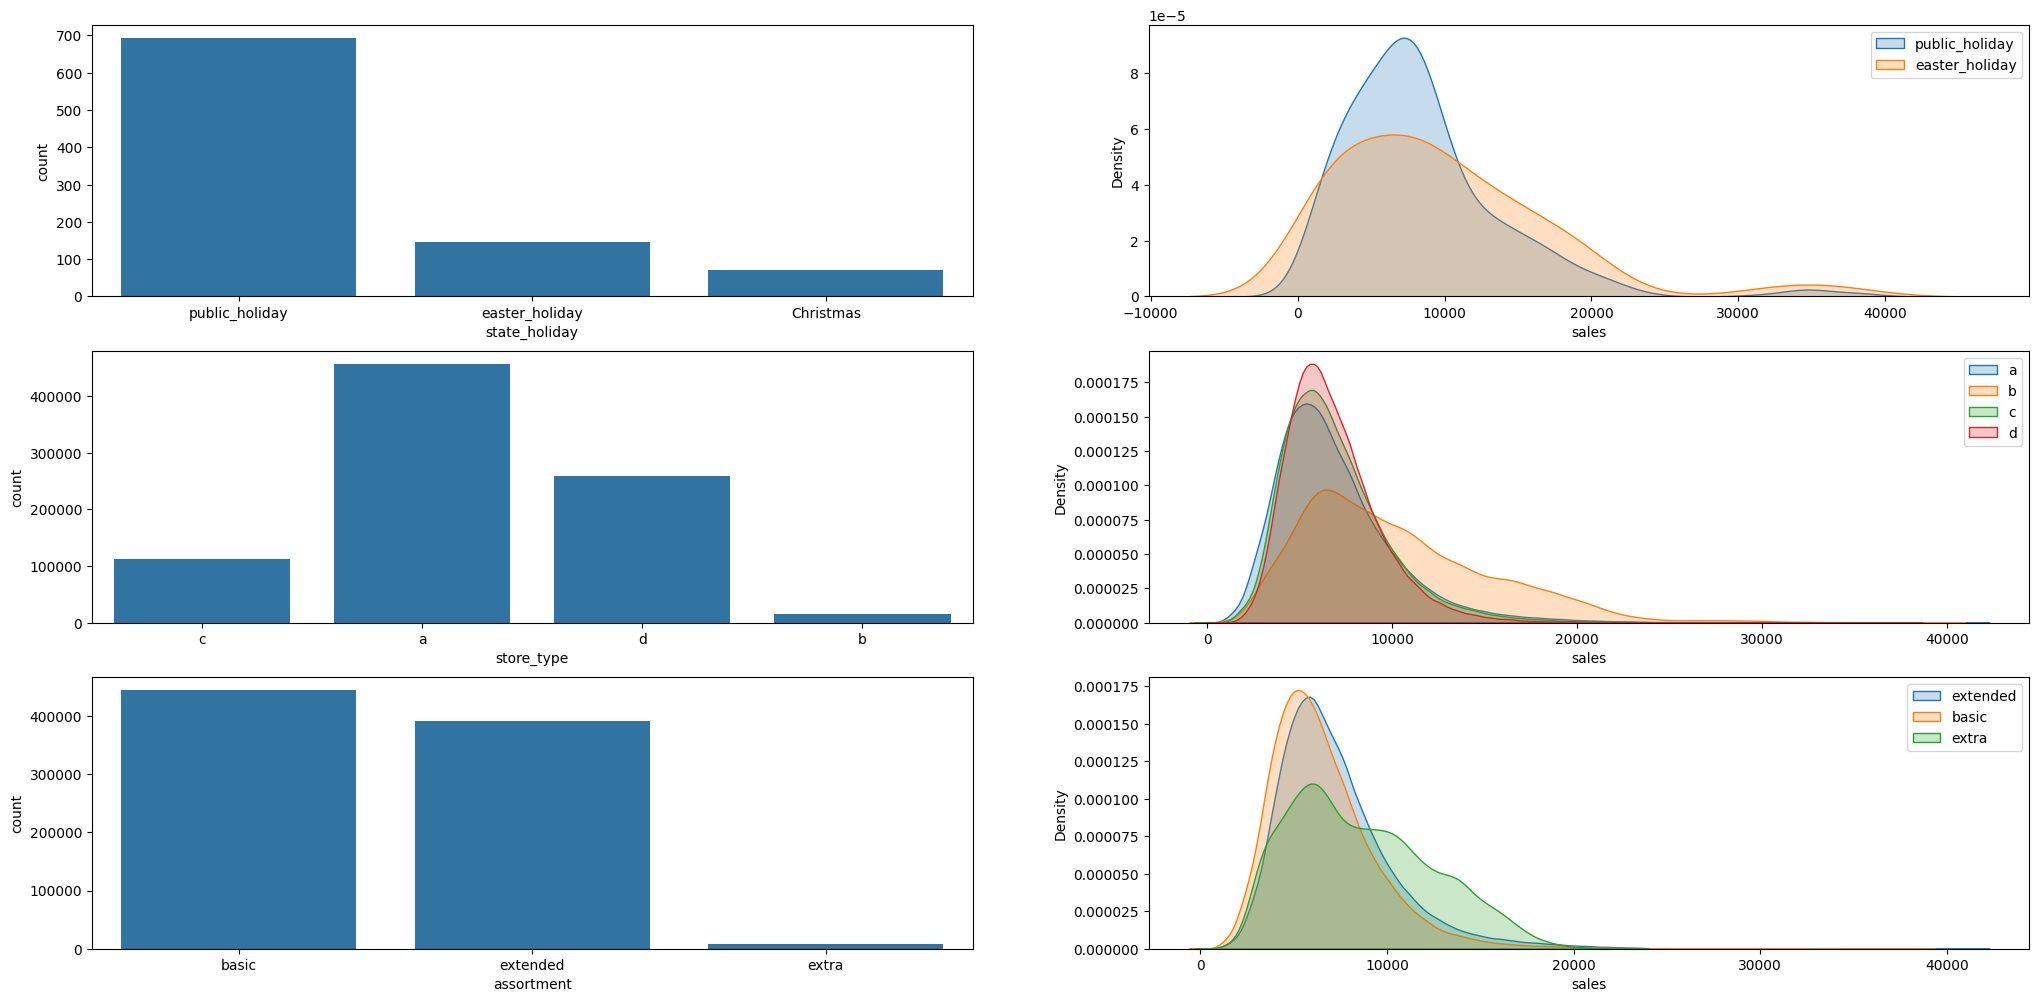

In [29]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()

## 4.2. Analise Bivariada

### **H1.** Lojas com maiores sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

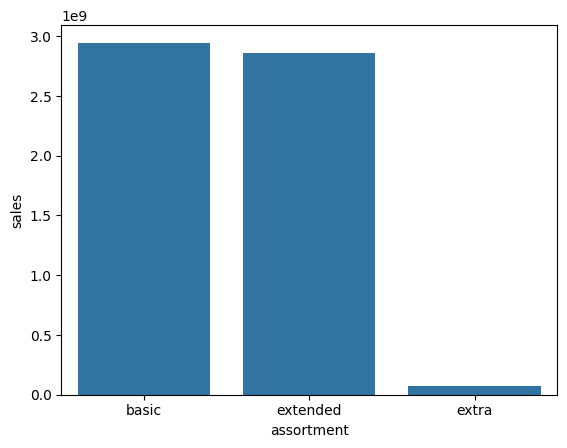

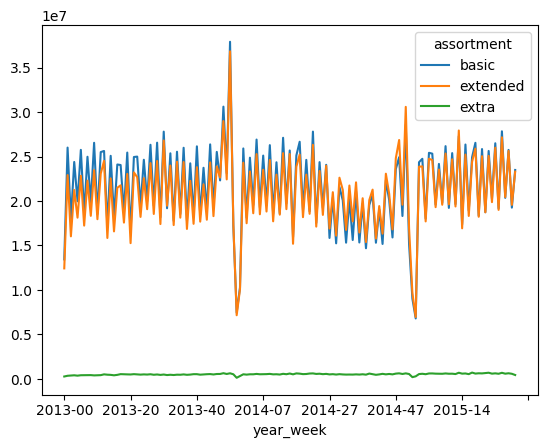

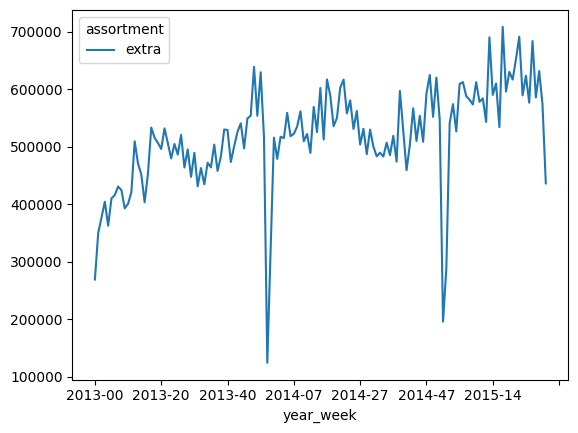

In [30]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index();
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index();
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

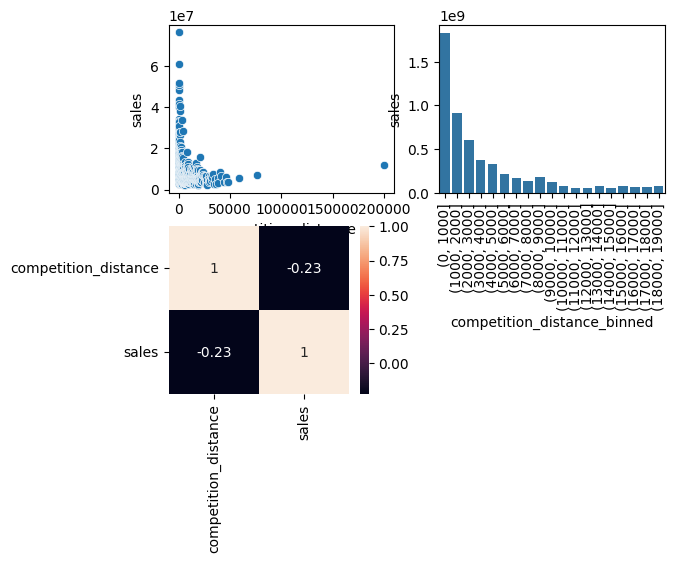

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson', numeric_only=True), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

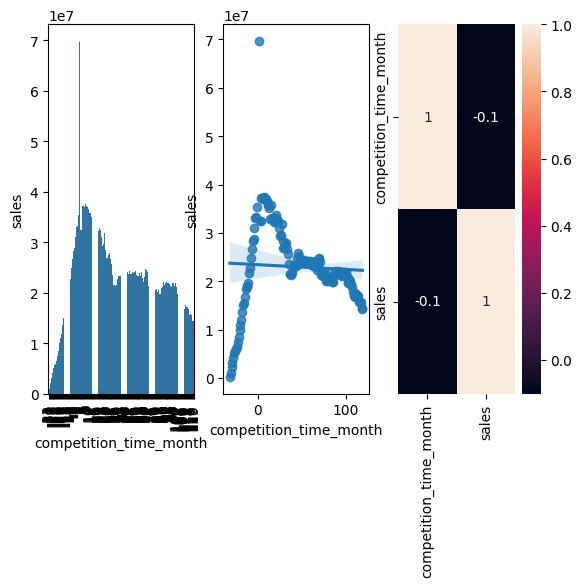

In [32]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson', numeric_only=True), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

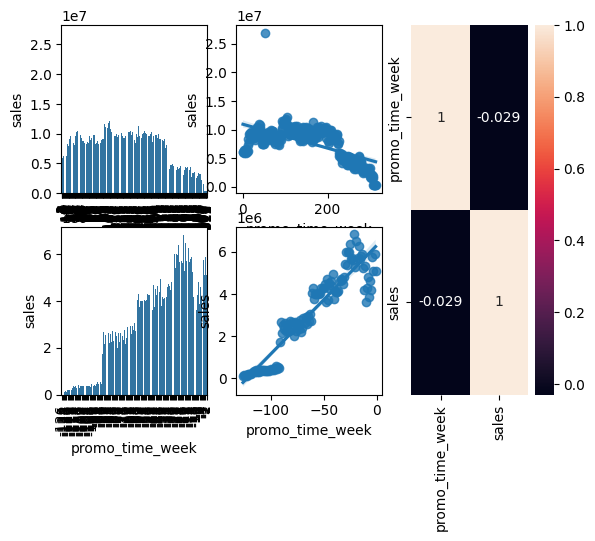

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos

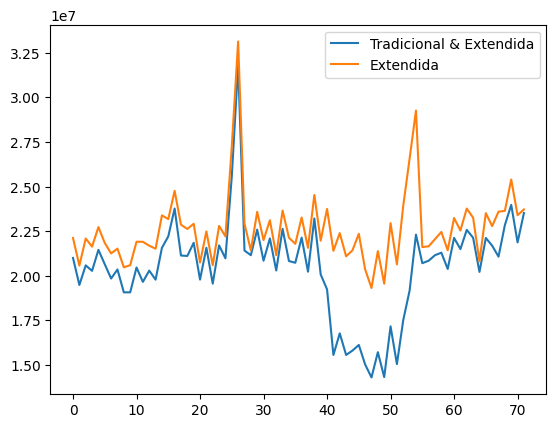

In [34]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

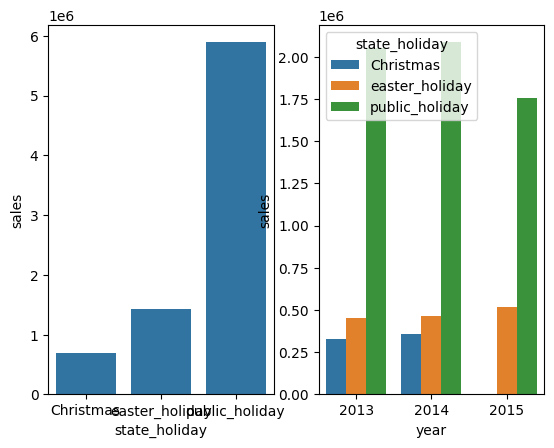

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

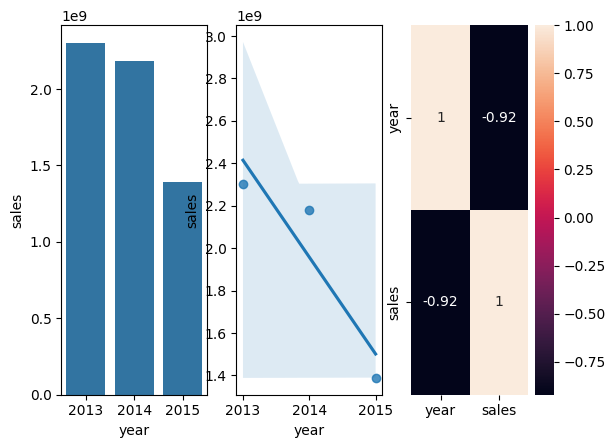

In [36]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

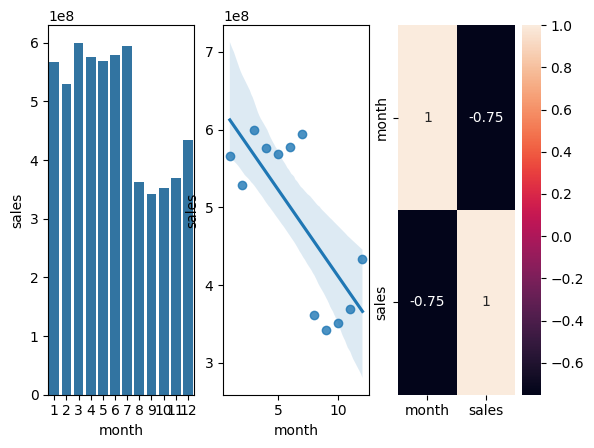

In [37]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

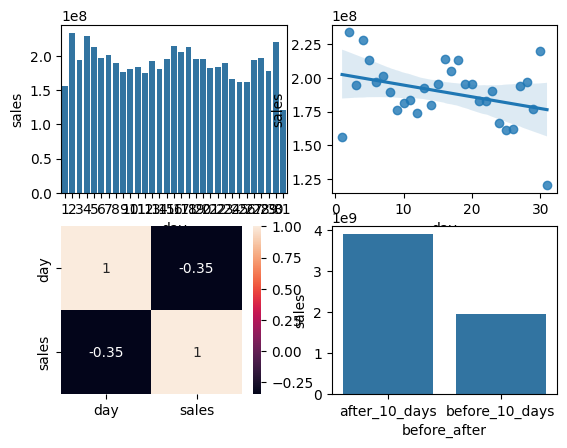

In [38]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

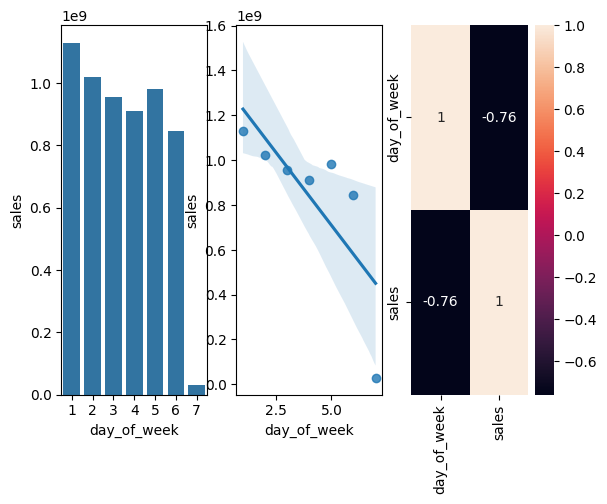

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

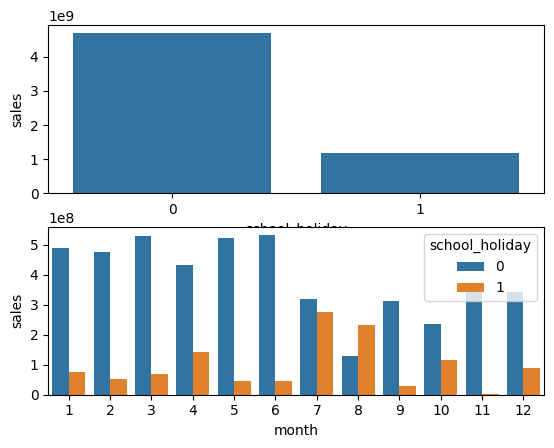

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipoteses

In [41]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

<Axes: >

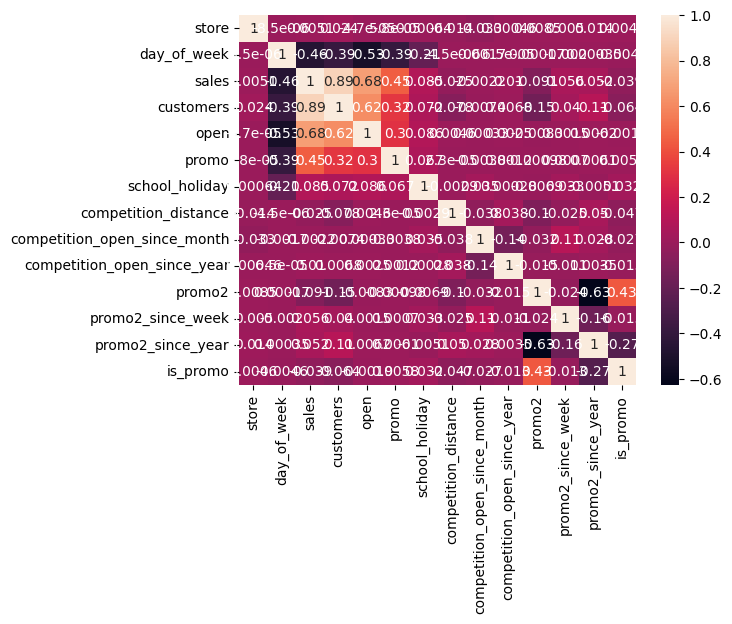

In [42]:
correlation = num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attributes

<Axes: >

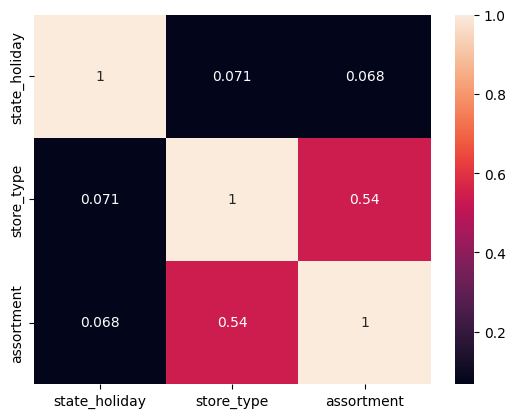

In [43]:
#Cramer é baseado no qui-quadrado
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap(d, annot = True)

# 5.0. PASSO 05 - DATA PREPARATION

In [44]:
df5 = df4.copy()

## 5.1. Normalização

NÃO HOUVE NORMALIZAÇÃO, POIS NENHUMA FEATURE TEM DISTRIBUIÇÃO NORMAL.

## 5.2. Rescaling

In [45]:
a = df5.select_dtypes(include = ["int64", "float64", "int", "UInt32"])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


                                                   Rescaling            


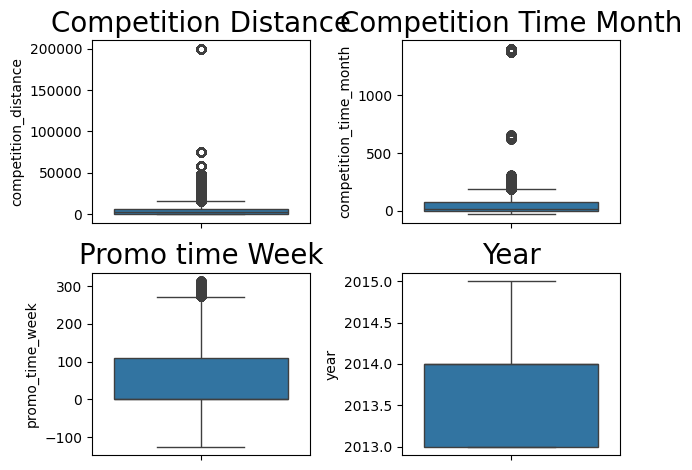

In [46]:
#Decidindo o rescaling a ser utilizado
print('                                                   Rescaling            ')

plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']).set_title('Competition Distance',  size = 20);

#outliers bem definido. Por isso vamos usar o robustscaler

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month']).set_title('Competition Time Month',  size = 20);

#outliers bem definido. Por isso vamos usar o robustscaler

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week']).set_title('Promo time Week',  size = 20);
#outliers não definido. Por isso vamos usar o MinMaxScaller


plt.subplot(2,2,4)
sns.boxplot(df5['year']).set_title('Year', size = 20);
#outliers não definido. Por isso vamos usar o MinMaxScaller

plt.tight_layout()

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )


# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )


# year
df5['year'] = mms.fit_transform( df5[['year']].values )


### Comparando as dimensões após e antes do rescaling

Comparação das dimensões após e antes o rescaling


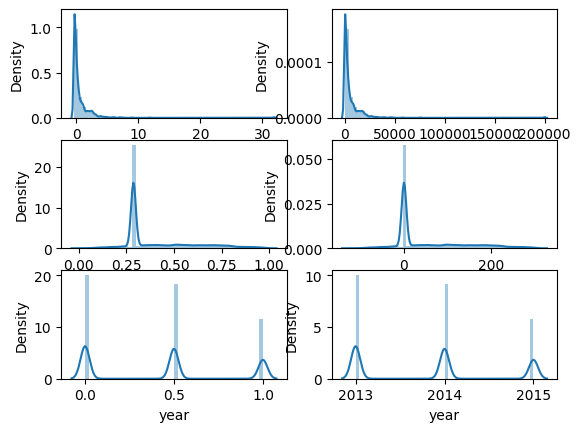

In [48]:
print('Comparação das dimensões após e antes o rescaling')


plt.subplot(3,2,1)
sns.distplot(df5['competition_distance']);

#outliers bem definido. Por isso vamos usar o robustscaler

plt.subplot(3,2,2)
sns.distplot(df4['competition_distance']);

#comparando com antes, vemos que a escala mudou

#####################################################################

#outliers bem definido. Por isso vamos usar o robustscaler

plt.subplot(3,2,3)
sns.distplot(df5['promo_time_week']);
#outliers não definido. Por isso vamos usar o MinMaxScaller
plt.subplot(3,2,4)
sns.distplot(df4['promo_time_week']);

#comparando com antes, vemos que a escala mudou

####################################################################


plt.subplot(3,2,5)
sns.distplot(df5['year']);
#outliers não definido. Por isso vamos usar o MinMaxScaller

plt.subplot(3,2,6)
sns.distplot(df4['year']);

#comparando com antes, vemos que a escala mudou

## 5.3. Transformação

### 5.3.1. Encoding

In [49]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [50]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  
                   'extra': 2, 
                   'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

<Axes: xlabel='sales', ylabel='Density'>

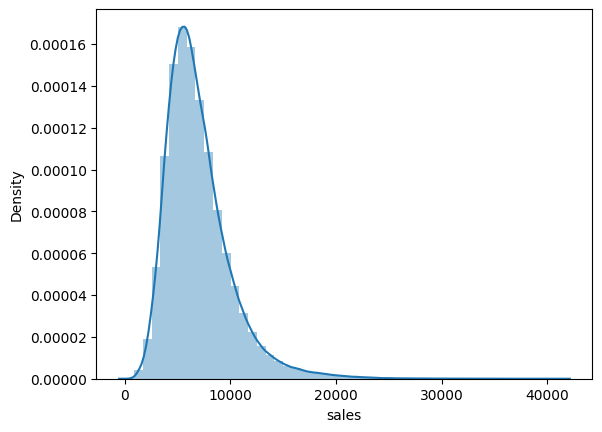

In [51]:
sns.distplot(df5['sales'])

<Axes: xlabel='sales', ylabel='Density'>

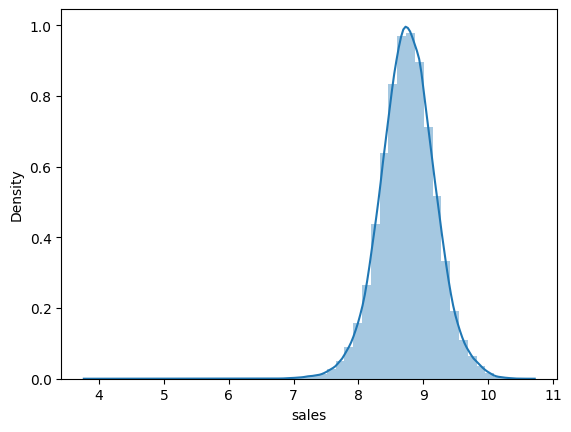

In [52]:
df5['sales'] = np.log1p( df5['sales'] )

sns.distplot(df5['sales'])

### 5.3.3. Nature Transformation

In [53]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [54]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [55]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [56]:
# #deletando variaveis que geraram variaveis novas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [57]:
df6[['store', 'date']].groupby('store').min().reset_index()
print('primeira data do conjunto de treino é em 02/01/2013')

df6[['store', 'date']].groupby('store').max().reset_index()
print('última data do conjunto de treino é em 31/07/2015')

print('\n primeira data:', df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7))

print('\n antes dessa data serão os dados de treino e após essa data serão os dados de teste ')

primeira data do conjunto de treino é em 02/01/2013
última data do conjunto de treino é em 31/07/2015

 primeira data: 2015-06-19 00:00:00

 antes dessa data serão os dados de treino e após essa data serão os dados de teste 


In [58]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [59]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values #pegar todas os valores somente
# y_train_n = y_train.values.ravel() #usar dentro do vetor

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [60]:
# cols_selected = boruta.support_.tolist()

# features selecionadas
# criando novo df porque o X_train está com values
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


# features nao selecionadas
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [61]:
#primeiro ciclo vamos usar as seleções do boruta + sin + date + sales

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add -  times series
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 PASSO 07 - MACHINE LEARNING MODELING

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#selecionando treino e teste de acordo com o boruta

In [79]:
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [74]:
#Model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() #chamamos de y a variavel que queremos prever

#prediction

#média de vendas das 'stores' e chamou de prediction
#o modelo de média preve o valor das vendas por meio da média de cada store 

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['prediction']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

#o np.expm1 é para 'desfazer' o log que aplicamos antes de fazer o modelo

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [66]:
#Model
lr = LinearRegression().fit(x_train, y_train)


#Prediction
yhat_lr = lr.predict(x_test)


# #Performance 
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [84]:
lr_result_cv = cross_validation (x_training, 5, 'Linear Regression', lr, verbose = True )

lr_result_cv 

# Isso significa que a semana selecionada anteriormente favorecia o RMSE do modelo


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [67]:
#Model - o Lasso tem o alpha que ele multiplica os pesos para ficar dentro de um range. 
lrr = Lasso(alpha = 0.0001).fit(x_train, y_train)


#Prediction
yhat_lrr = lrr.predict(x_test)


# #Performance 
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565


### 7.3.1 Linear Regression Regularized Model Lasso - Cross Validation

In [86]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


## 7.4 Random Forest Regressor

In [68]:
 #Model 
rf = RandomForestRegressor(n_estimators = 100 , n_jobs = -1, random_state = 77).fit(x_train, y_train)

#Prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,684.440012,0.100626,1017.501018


### 7.4.1. Random forest regressor - cross validation

In [88]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,Random Forest,837.8 +/- 215.81,0.12 +/- 0.02,1258.38 +/- 317.84


## 7.5 XGBoost Regressor

In [72]:
#Model - o Lasso tem o alpha que ele multiplica os pesos para ficar dentro de um range. 
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)


#Prebdiction
yhat_xgb = model_xgb.predict(x_test)


#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1685.0258,0.250304,2463.213643


### 7.5.1. XGBoost Regressor - cross validation

In [89]:
xbg_result_cv = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
xbg_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [76]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')


#apesar do resultado, pois ainda é necessário o crossvalidation 

,Model Name,MAE,MAPE,RMSE
0,Random Forest,684.440012,0.100626,1017.501018
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1685.025800,0.250304,2463.213643
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1867.907526,0.291894,2675.988565


### 7.6.2 Real Performance - Cross Validation

In [90]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xbg_result_cv])
modelling_result_cv.sort_values('RMSE CrossValidation')

,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,Random Forest,837.8 +/- 215.81,0.12 +/- 0.02,1258.38 +/- 317.84
0,XGBoost Regressor,1859.87 +/- 289.14,0.25 +/- 0.01,2688.49 +/- 432.73
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2081.64 +/- 298.77,0.3 +/- 0.02,2955.91 +/- 471.18


# 8.0 Passo 8 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [91]:
param = {
        'n_estimators': [1500,1700,2500,3000,3500],
        'eta': [0.1,0.03],
        'max_depth': [3,5,9],
        'subsample': [0.1,0.5,0.7],
        'colsample_bytree': [0.3,0.7,0.9],
        'min_child_weight': [3,5,8]}

max_eval = 10

In [95]:
final_result = pd.DataFrame()
for i in range(max_eval):
    #escolha de parâmetros aleatoriamente 
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    #Model 
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'] )


    #Prebdiction
    result = cross_validation(x_training, 2, 'XGBOOST regressor', model_xgb, verbose = True)
    final_result = pd.concat([final_result, result])  
        
final_result.sort_values('RMSE CrossValidation')       

{'n_estimators': 3000, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 5}

KFold Number: 2

KFold Number: 1


,Model Name,MAE CrossValidation,MAPE CrossValidation,RMSE CrossValidation
0,XGBOOST regressor,893.44 +/- 106.76,0.12 +/- 0.01,1268.39 +/- 178.39
0,XGBOOST regressor,1221.73 +/- 54.67,0.16 +/- 0.0,1782.28 +/- 104.13


## 8.2 Final Model

Melhor (menor RMSE) modelo foi com o 7 loop. Então os paramêtros escolhidos foram:

'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 5

In [96]:
param_tuned = {
        'n_estimators':1500 ,
        'eta': 0.03 ,
        'max_depth': 5 ,
        'subsample': 0.7,
        'colsample_bytree':0.3 ,
        'min_child_weight': 5 }

max_eval = 2

In [97]:
# Model 
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                      n_estimators = param_tuned['n_estimators'],
                                      eta = param_tuned['eta'],
                                      max_depth = param_tuned['max_depth'],
                                      subsample = param_tuned['subsample'],
                                      colsample_bytree = param_tuned['colsample_bytree'],
                                      min_child_weight = param_tuned['min_child_weight'] ).fit(x_train, y_train)


# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
result = ml_error('XGBOOST regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

In [98]:
result

,Model Name,MAE,MAPE,RMSE
0,XGBOOST regressor,1066.670688,0.160526,1547.070789
